This is meant to be an afternoon PoC.

- **goal**: being able to automatically aggregate reports on the same vulnerability
- **why**: 
    - with the growing amount of competitive auditors and auditing plateform, judges waste time going through all the reports and grouping those belonging to the same vulnerability
    - if you want to review all the solodit issues, this might be used to reduce the number of issues to review as some overlap exist across contests
- **scope**: using Sherlock audit repo, being able to classify with at least 80% accuracy vulnerabilties while training on 25% of the dataset

Raw ideas and notes:
- a custom dictionnary is needed: for instance with brands like `Chainlink` related vulnerabilities
- code blocks may need to be removed because all solidity tokens will overlap across contests and won't add usefull info (not sure about that, worth a try)
- some reports will overlap across contests (not a bad thing, just something to keep in mind)
- may need to remove report's author name as they are at the begining of each doc

Vocabulary:
- `report` the .md file
- `vulnerability` the folder containing the reports

Example:

```
sherlock-audit
 |-2022-09-knox-judging  <<< contest
 | |-022-M
 | | |-047.md
 | |-006-M               <<< vulnerability
 | | |-058.md            <<< report
 | | |-113.md
```

The goal is to be able given one report to recommend another report belonging to the same vulnerability.

### Installation

You may need to [install github cli](https://cli.github.com/manual/installation)

In [ ]:
%%bash
apt install gh

1. download all the judging repositories from [Sherlock's GitHub repo](https://github.com/sherlock-audit)
2. delete all the `invalid` and `false` reports

In [ ]:
%%bash
gh repo list sherlock-audit --limit 1000 | while read -r repo _; do
  if [[ $repo == *-judging ]]
  then
	  gh repo clone "$repo" "$repo"
  fi
done

# removing {contest}/{invalid findings}
find sherlock-audit -maxdepth 2 \( -name "false" -o -name "invalid" -o -name "low-info" -o -name "closed" \) -type d -exec rm -rvf {} +

In [ ]:
!pip install pandas 
!pip install matplotlib 
!pip install gensim
!pip install scikit-learn

In [12]:
! find sherlock-audit | head -n 20 | sed -e "s/[^-][^\/]*\// |/g" -e "s/|\([^ ]\)/|-\1/" 

sherlock-audit
 |-2022-09-knox-judging
 | |-022-M
 | | |-047.md
 | |-006-M
 | | |-058.md
 | | |-113.md
 | | |-065.md
 | | |-149.md
 | | |-059.md
 | | |-103.md
 | | |-088.md
 | | |-127.md
 | | |-022.md
 | | |-152.md
 | | |-034.md
 | | |-081.md
 | | |-137-report.md
 | | |-061.md
 | | |-019.md
find: ‘standard output’: Broken pipe
find: write error


### Creating the dataset

In [1]:
import pathlib
import pandas as pd

REPORT_ROOT = "sherlock-audit"
REPORT_CSV = "reports.csv"

In [2]:
# Here we create the CSV listing all the reports (execute once)

reports_root = pathlib.Path(REPORT_ROOT)    

entries = []

for finding in reports_root.glob("*-judging/*-*/*.md"):
    entry = {
        "contest": finding.parents[1].name,   # eg 2022-09-knox
        "vuln": finding.parents[0].name,      # eg 022-M
        "report": finding.name,               # eg 103.md
        "path": finding.resolve()             # full path
    }

    entry["vuln_id"] = f"""{entry["contest"]}__{entry["vuln"]}"""     # eg 2022-09-knox__022-M
    entry["report_id"] = f"""{entry["vuln_id"]}__{entry["report"]}""" # usefull for word2vec
    entries.append(entry)

pd.DataFrame(entries).to_csv(REPORT_CSV, index=False)
        

In [66]:
df = pd.read_csv(REPORT_CSV)

print(f"""We have {len(df)} reports grouped in {len(df.vuln_id.unique())} vulnerabilities""")

df.sample(5)

We have 8981 reports grouped in 2581 vulnerabilities


,contest,vuln,report,path,vuln_id,report_id
46,2022-09-knox-judging,025-M,094.md,/home/max/projects/reports-sorter/sherlock-aud...,2022-09-knox-judging__025-M,2022-09-knox-judging__025-M__094.md
1839,2023-02-surge-judging,014-M,190.md,/home/max/projects/reports-sorter/sherlock-aud...,2023-02-surge-judging__014-M,2023-02-surge-judging__014-M__190.md
6279,2023-05-perennial-judging,025-M,245.md,/home/max/projects/reports-sorter/sherlock-aud...,2023-05-perennial-judging__025-M,2023-05-perennial-judging__025-M__245.md
5665,2023-05-USSD-judging,012-H,266.md,/home/max/projects/reports-sorter/sherlock-aud...,2023-05-USSD-judging__012-H,2023-05-USSD-judging__012-H__266.md
1258,2023-05-Index-judging,001-H,054.md,/home/max/projects/reports-sorter/sherlock-aud...,2023-05-Index-judging__001-H,2023-05-Index-judging__001-H__054.md


Text(0.5, 1.0, 'Histogram of the number of reports per vulnerabilty')

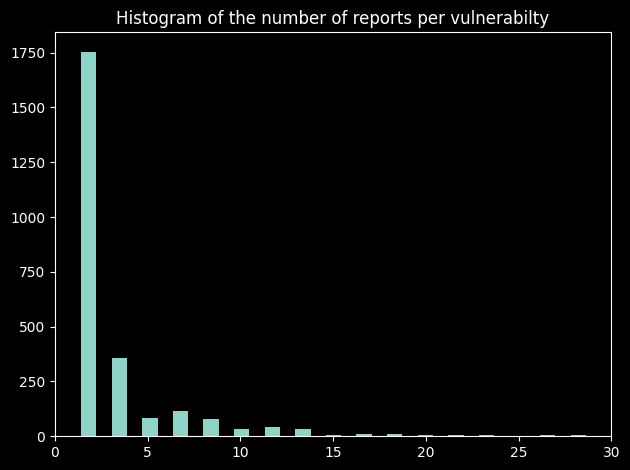

In [67]:
# What is the distribution of the number of findings per vulnerability per contest (vuln_id)?
import matplotlib.pyplot as plt
plt.style.use('dark_background')

n_finding_per_vuln = df[['vuln_id', 'report']].groupby(['vuln_id']).agg(len)['report'].values

fig, ax = plt.subplots(tight_layout=True)
hist = ax.hist(n_finding_per_vuln, bins=100, rwidth=0.5)
ax.set_xlim(0, 30)
ax.set_title('Histogram of the number of reports per vulnerabilty')

Let's split the reports in two sets (training and testing) keeping the vulnerabilities whole in each set

In [43]:
import numpy as np
from sklearn import model_selection

split_type = "PER_VULNERABILITY"
TRAIN_SPLIT = 0.7 
MIN_REPORT_PER_VULN = 3 

df = pd.read_csv(REPORT_CSV)

if(MIN_REPORT_PER_VULN > 0):
    # The goal is to find reports that belongs to the same vulnerability
    # so solo ones should be discarded during training and testing
    more = df.vuln_id.value_counts()
    df = df[df.vuln_id.isin(more[more.gt(MIN_REPORT_PER_VULN)].keys())]

train_df, test_df = model_selection.train_test_split(df, train_size=TRAIN_SPLIT, stratify=df["vuln_id"])

n_vulnerabilities_train = len(train_df['vuln_id'].value_counts())
n_vulnerabilities_test = len(test_df['vuln_id'].value_counts())
print(f"""{len(df)} initial dataset length
{len(train_df)} training samples 
{len(test_df)} testing samples ({TRAIN_SPLIT} train split) 
{n_vulnerabilities_test} / {n_vulnerabilities_train} different vulnerabilities 
chance of classify correctly randomly is {(1/n_vulnerabilities_test)*100:.4f}% (if same number of reports per vulnerability)""")

6243 initial dataset length
4370 training samples 
1873 testing samples (0.7 train split) 
617 / 617 different vulnerabilities 
chance of classify correctly randomly is 0.1621% (if same number of reports per vulnerability)


## Train the `doc2vec` model

`gensim.Doc2Vec` accepts an iterable for training so we'll make one now

https://radimrehurek.com/gensim_3.8.3/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py

In [46]:
import gensim

def report_preprocess(doc): 
    translation_table = dict.fromkeys(map(ord, ',.!;#`'), None)
    doc = doc.replace('-', ' ')
    doc = doc.translate(translation_table).split()
    doc = doc[1:] # removing username and severity
    doc = [d.lower() for d in doc]
    return doc

def load_reports(report_set):
    for index_report, report_path in enumerate(report_set["path"].values):
        with open(report_path, 'r') as f:
            tokens = report_preprocess(f.read())
            yield gensim.models.doc2vec.TaggedDocument(tokens, [f"{index_report}"])

def load_fullreport(report_set, index):
    report_path = report_set["path"].values[index]
    with open(report_path, 'r') as f:
        tokens = report_preprocess(f.read())
        return tokens

In [59]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=225, 
                                      min_count=3, 
                                      epochs=85, 
                                      max_vocab_size=None, 
                                      workers=30, 
                                      dm_concat=0)

model.build_vocab(load_reports(train_df))

train_corpus = list(load_reports(train_df))
model.train(train_corpus, 
            total_examples=model.corpus_count, 
            epochs=model.epochs)

To evaluate, we'll go through all the test documents and see if we can find if the `top_n` documents found are belonging to the same vulnerability.

In [69]:
ranks = []

top_n = 1
get_vuln_id = lambda df, doc_id: df.iloc[[doc_id]]['vuln_id'].values[0]

for doc_id in range(len(test_df)):
    inferred_vector = model.infer_vector(load_fullreport(test_df, doc_id))
    sims = model.dv.most_similar([inferred_vector], topn=top_n)
    target_vuln_id = get_vuln_id(test_df, doc_id)

    found = 0
    for n in range(top_n):
        similar_doc_id = int(sims[n][0])
        found = found or (get_vuln_id(train_df, similar_doc_id) == target_vuln_id)

    ranks.append(found)

top_n_accuracy = sum(ranks) / len(ranks)
print(f"{top_n_accuracy * 100:.2f}% top-{top_n} accuracy")

55.53% top-1 accuracy
